In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load dataset
df = pd.read_csv("karachi_aqi_features.csv", parse_dates=["timestamp"])

# Quick look
print(df.shape)
print(df.dtypes)

(1980, 24)
timestamp          datetime64[ns, UTC]
aqi                              int64
co                             float64
no                             float64
no2                            float64
o3                             float64
so2                            float64
pm2_5                          float64
pm10                           float64
nh3                            float64
hour                             int64
day                              int64
month                            int64
weekday                          int64
is_weekend                       int64
lag_1                          float64
lag_2                          float64
lag_24                         float64
rolling_mean_6h                float64
rolling_std_12h                float64
aqi_diff                       float64
aqi_pct_change                 float64
pm_ratio                       float64
gas_ratio                      float64
dtype: object


In [ ]:
# Checking Missing Values and Summary

print(df.isnull().sum())
print(df.describe())

timestamp           0
aqi                 0
co                  0
no                  0
no2                 0
o3                  0
so2                 0
pm2_5               0
pm10                0
nh3                 0
hour                0
day                 0
month               0
weekday             0
is_weekend          0
lag_1               1
lag_2               2
lag_24             24
rolling_mean_6h     5
rolling_std_12h    11
aqi_diff            1
aqi_pct_change      1
pm_ratio            3
gas_ratio           0
dtype: int64
               aqi           co           no          no2           o3  \
count  1980.000000  1980.000000  1980.000000  1980.000000  1980.000000   
mean     72.519192    79.059025     0.003364     0.085328    47.115652   
std      26.366966     8.533639     0.004996     0.084717     7.725811   
min       0.000000    66.880000     0.000000     0.030000    30.250000   
25%      54.000000    74.220000     0.000000     0.060000    41.890000   
50%      70.000

In [6]:
# Handle missing values

df = df.dropna().reset_index(drop=True)

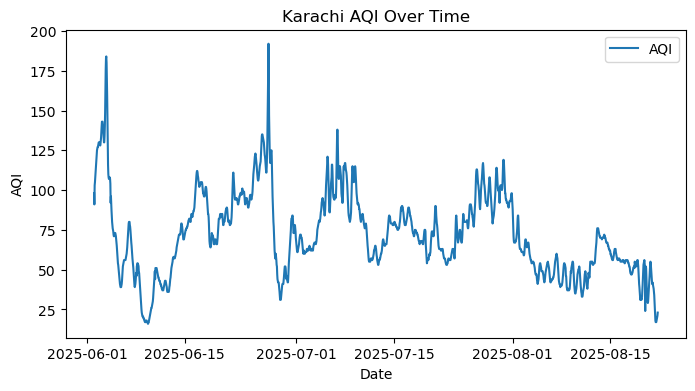

In [8]:
# Time Series Analysis

plt.figure(figsize=(8,4))
plt.plot(df["timestamp"], df["aqi"], label="AQI")
plt.title("Karachi AQI Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()

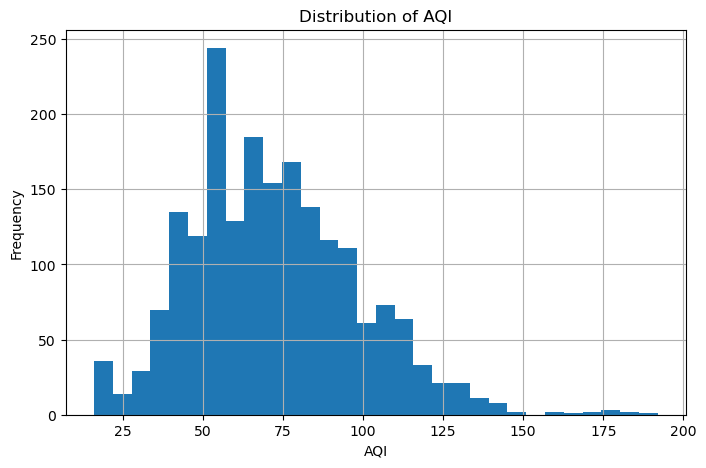

In [10]:
# Distribution of AQI

df["aqi"].hist(bins=30, figsize=(8,5))
plt.title("Distribution of AQI")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.show()

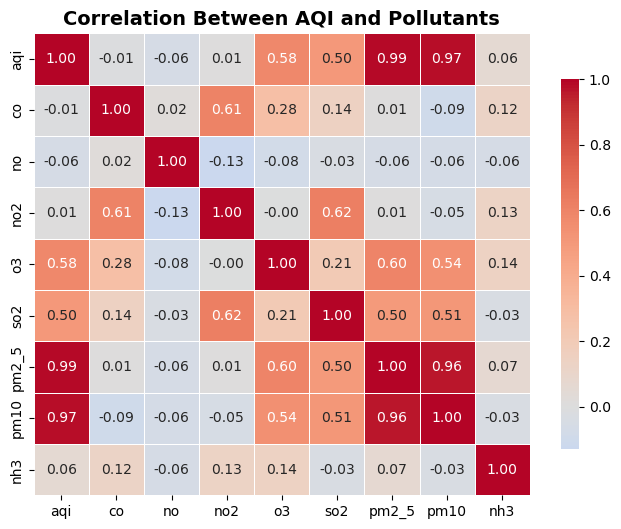

In [ ]:
# Select only numeric columns
df_num = df.select_dtypes(include=['number'])

# Compute correlation matrix
corr = df_num.corr()

# Focus only on pollutants + AQI
pollutants = ["aqi", "co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]
corr_pollutants = corr.loc[pollutants, pollutants]

# Plot cleaner heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(corr_pollutants, annot=True, cmap="coolwarm", center=0, fmt=".2f",
            linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title("Correlation Between AQI and Pollutants", fontsize=14, weight="bold")
plt.show()


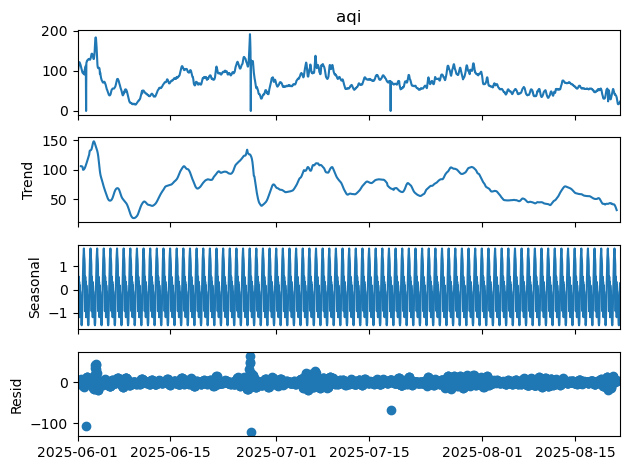

In [ ]:
# Seasonal & Trend Patterns

# Make sure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Set index and aggregate hourly (avoid duplicates)
df_ts = df.set_index("timestamp")["aqi"].resample("h").mean()

# Fill small gaps
df_ts = df_ts.interpolate()

# Seasonal decomposition (24 = daily cycle for hourly data)
decomp = seasonal_decompose(df_ts, model="additive", period=24)
decomp.plot()
plt.show()

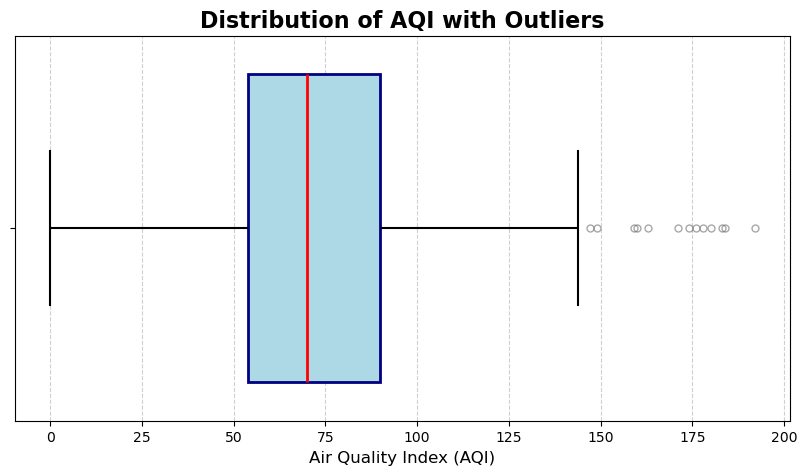

In [ ]:
# Outlier Detection

plt.figure(figsize=(10,5))
sns.boxplot(
    x=df["aqi"], 
    color="skyblue", 
    fliersize=5,        # size of outlier points
    linewidth=2, 
    boxprops=dict(facecolor="lightblue", edgecolor="navy"),
    medianprops=dict(color="red", linewidth=2),
    whiskerprops=dict(color="black", linewidth=1.5),
    capprops=dict(color="black", linewidth=1.5),
    flierprops=dict(marker='o', color='red', alpha=0.6)
)

plt.title("Distribution of AQI with Outliers", fontsize=16, weight="bold")
plt.xlabel("Air Quality Index (AQI)", fontsize=12)
plt.grid(axis='x', linestyle="--", alpha=0.6)
plt.show()


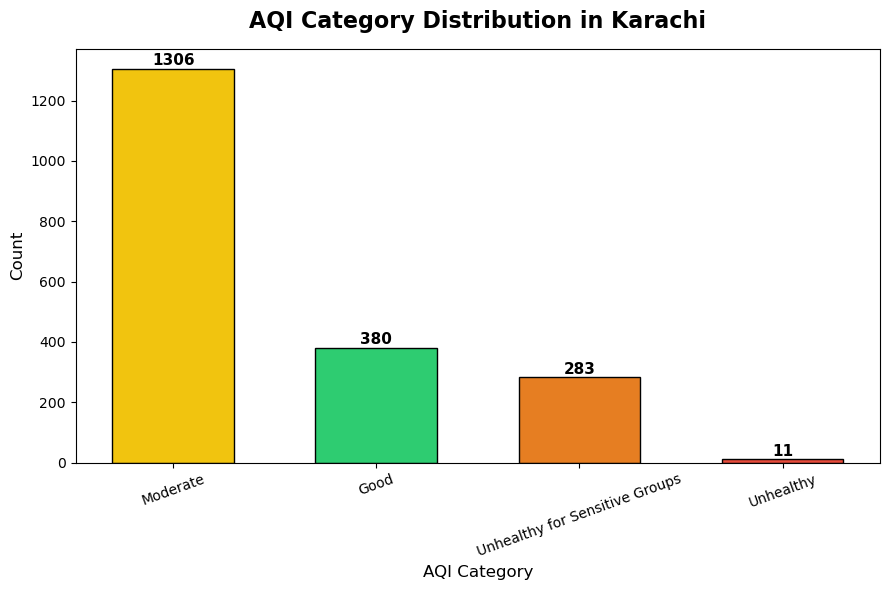

In [ ]:
# AQI Category Distribution

category_colors = {
    "Good": "#2ecc71",                       # Green
    "Moderate": "#f1c40f",                   # Yellow
    "Unhealthy for Sensitive Groups": "#e67e22", # Orange
    "Unhealthy": "#e74c3c",                  # Red
    "Very Unhealthy": "#8e44ad",             # Purple
    "Hazardous": "#7f0000"                   # Dark Red
}

# Count AQI categories
category_counts = df["AQI_Category"].value_counts()

# Plot with custom colors
plt.figure(figsize=(9,6))
bars = plt.bar(category_counts.index, category_counts.values,
               color=[category_colors[cat] for cat in category_counts.index],
               edgecolor="black", width=0.6)

# Add value labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 2, 
             str(int(bar.get_height())), 
             ha="center", va="bottom", fontsize=11, weight="bold")

# Add title and labels
plt.title("AQI Category Distribution in Karachi", fontsize=16, weight="bold", pad=15)
plt.xlabel("AQI Category", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Rotate x labels for readability if needed
plt.xticks(rotation=20)

plt.tight_layout()
plt.show()

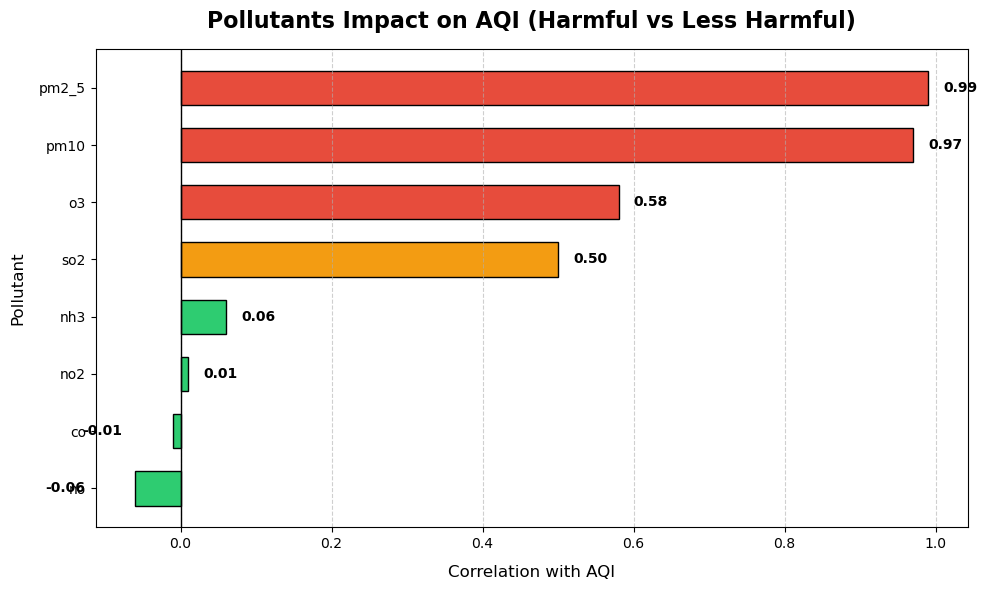

In [27]:
# Pollutants correlation values
corr_values = {
    "no": -0.06, "co": -0.01, "no2": 0.01, "nh3": 0.06,
    "so2": 0.50, "o3": 0.58, "pm10": 0.97, "pm2_5": 0.99
}

# Convert to Series and sort
corr = pd.Series(corr_values).sort_values()

# Color scheme: red = strong, orange = moderate, green = weak/negative
colors = ["#e74c3c" if x > 0.5 else ("#f39c12" if x > 0.2 else "#2ecc71") for x in corr.values]

# Create figure
plt.figure(figsize=(10,6))

bars = plt.barh(corr.index, corr.values, 
                color=colors, edgecolor="black", height=0.6)

# Add grid for readability
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Add correlation values at bar ends
for bar, value in zip(bars, corr.values):
    plt.text(bar.get_width() + (0.02 if value > 0 else -0.12), 
             bar.get_y() + bar.get_height()/2,
             f"{value:.2f}", va="center", fontsize=10, weight="bold", color="black")

# Axis and title
plt.axvline(0, color="black", linewidth=1)
plt.title("Pollutants Impact on AQI (Harmful vs Less Harmful)", fontsize=16, weight="bold", pad=15)
plt.xlabel("Correlation with AQI", fontsize=12, labelpad=10)
plt.ylabel("Pollutant", fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()